In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os


In [6]:
data = np.load("features.npz")
print("Available keys in npz:", data.files)


Available keys in npz: ['features', 'labels']


In [7]:
data = np.load("features.npz")
X = data['features']  # shape: (samples, 128, 216, 1)
y = data['labels']  # shape: (samples,)

print("Original shape of X:", X.shape)
print("Original shape of y:", y.shape)


Original shape of X: (15921, 128, 216, 1)
Original shape of y: (15921,)


In [11]:
# Optional: if labels need cleaning
import pandas as pd

# Convert to DataFrame to clean easily
labels_df = pd.Series(y)
labels_df = labels_df.replace({
    'fearful': 'fear',
    'calm': 'neutral',
    'ps': 'neutral'
})

y = labels_df.to_numpy()


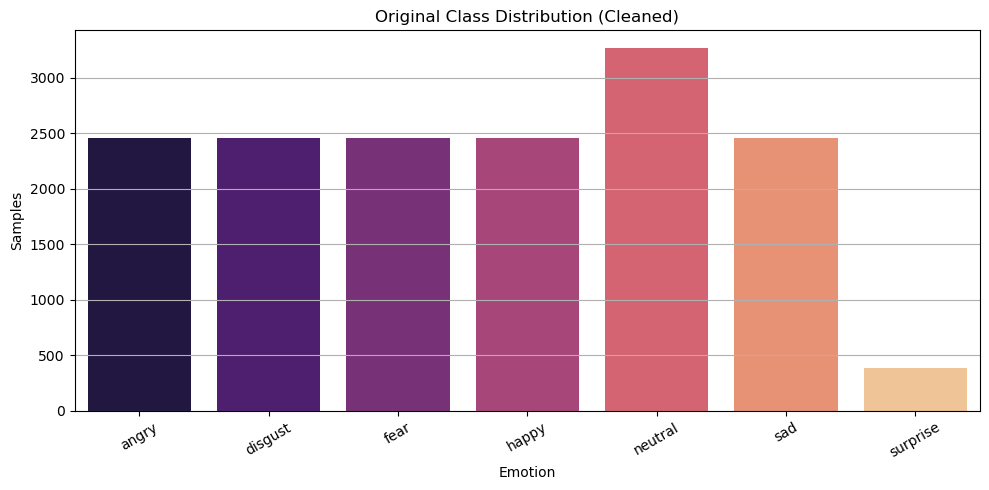

In [12]:
def plot_class_distribution(labels, title):
    counts = Counter(labels)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="magma")
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Samples")
    plt.grid(axis='y')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

plot_class_distribution(y, "Original Class Distribution (Cleaned)")


Balanced shape: (2681, 128, 216, 1) (2681,)


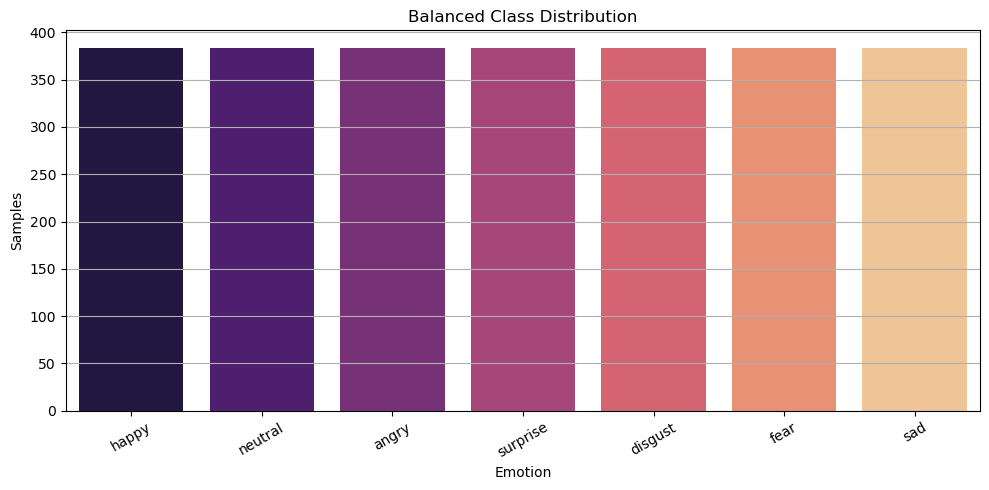

In [13]:
def balance_classes(X, y):
    unique_classes = np.unique(y)
    counts = Counter(y)
    min_count = min(counts.values())

    X_bal, y_bal = [], []
    for emotion in unique_classes:
        idx = np.where(y == emotion)[0]
        X_class, y_class = X[idx], y[idx]
        X_down, y_down = resample(X_class, y_class, replace=False, n_samples=min_count, random_state=42)
        X_bal.append(X_down)
        y_bal.append(y_down)

    return np.concatenate(X_bal), np.concatenate(y_bal)

X, y = balance_classes(X, y)

# Shuffle
indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]

print("Balanced shape:", X.shape, y.shape)
plot_class_distribution(y, "Balanced Class Distribution")


In [14]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("Classes:", le.classes_)
print("Categorical shape:", y_categorical.shape)


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Categorical shape: (2681, 7)


In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (2144, 128, 216, 1) Val: (537, 128, 216, 1)


In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\ALL\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 216, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 216, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 108, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 108, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 108, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 108, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 54, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 54, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 55296)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      14,156,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251,399 (54.36 MB)

 Trainable params: 14,250,951 (54.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
callbacks = [
    ModelCheckpoint("vgg_best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]


In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2292 - loss: 8.6014
Epoch 1: val_accuracy improved from -inf to 0.21601, saving model to vgg_best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.2293 - loss: 8.5361 - val_accuracy: 0.2160 - val_loss: 1.8379 - learning_rate: 5.0000e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2599 - loss: 1.7662
Epoch 2: val_accuracy improved from 0.21601 to 0.21974, saving model to vgg_best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.2599 - loss: 1.7661 - val_accuracy: 0.2197 - val_loss: 2.0679 - learning_rate: 5.0000e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2733 - loss: 1.7465
Epoch 3: val_accuracy improved from 0.21974 to 0.25885, saving model to vgg_best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.2734 - loss: 1.7463 - val_accuracy: 0.2588 - val_loss: 3.2021 - learning_rate: 5.0000e-04
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s